# Complexity Hotspots

### 1. You must consider only the app folder from the Mastodon repository
(i.e., https://github.com/mastodon/mastodon).

In [1]:
import pydriller
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

### 2. Decide on the granularity of your analysis of software entities (e.g., source code files); describe why you selected this specific granularity.

In [36]:
# run inside \mastodon\app
git ls-files | awk -F . '{print $NF}' | sort | uniq -c | sort -n -r | awk '{print $2,$1}' | head -10
rb 895
js 437
haml 214
json 178
png 37
erb 33
scss 32
svg 24
woff2 5
woff 5

<i> .rb means ruby files, these are the most common files in the app folder. </i>

### 3. Create a list of all these entities, as they appear in the latest stable release of Mastodon (i.e., tag v3.5.3). 

<i> **Number of entities for tagged v3.5.3.**

First we change to that version with the command "git checkout tags/v3.5.3".
Then we create a pydriller git object to obtain the number of files we had at that time.
We can also find the defined entities with the following commands: </i>

In [ ]:
git checkout tags/v3.5.3
cd app
find . -type f -name "*.rb" | awk -F / '{print $(NF)}' > mastodon_rubyfiles.txt

In [6]:
mastodon_path = "C:\\Users\\szymo\\Desktop\\SOSy_repos\\mastodon"
mastodon_app_path = os.path.join(mastodon_path, "app")
git = pydriller.git.Git(mastodon_path)
files = git.files()
total=[]
for file in files:
    if mastodon_app_path in file and ".rb" in file:
        total.append(file)
entities = []
for f in total:
    entities.append(f.split("\\")[-1])
print("Total number of entities for tag v3.5.3: ", len(entities))

# save entities to pickle
with open('entities.pickle', 'wb') as handle:
    pickle.dump(entities, handle, protocol=pickle.HIGHEST_PROTOCOL)

Total number of entities for tag v3.5.3:  815


In [9]:
# OTHER VERSION - to be corrected?

repo = pydriller.Repository(mastodon_path, to_tag="v3.5.3")
latest_release_commits = list(repo.traverse_commits())
files = {}
for commit in latest_release_commits:
    for m in commit.modified_files:
        # keep only files with .rb extension
        if m.filename.endswith('.rb'):
            # FILE IS ADDED 
            if m.new_path is not None and m.old_path is None:
                # example:  m.new_path = 'app/sth.rn' & old_path = None
                files[m.new_path] = m.filename
            # FILE IS DELETED
            elif m.new_path is None and m.old_path is not None:
                # example:  m.new_path = None         & old_path = 'app/sth.rn'
                files[m.old_path] = 'deleted'
            # else:
            #     if m.new_path != m.old_path:
            #         print(m)
            #         files[m.new_path] = m.filename
            #         files[m.old_path] = 'deleted'

# keep only files that are not deleted
files_filtered = {k: v for k, v in files.items() if v != 'deleted'}

# keep only the files that are in app/ 
files_entities = {k: v for k, v in files_filtered.items() if k.startswith('app\\')}

# get just the names
files_entities_names = list(files_entities.values())
print("Number of files: ", len(files_entities_names))

Number of files:  825


### 4. Decide on the type of complexity you want to measure for your software entities and explain why you selected this type.

<i> We decided to use the Cyclomatic Complexity. It is a quantitative measure of the number of linearly independent paths inside the code and is defined as “the amount of decision logic in a source code function”. Meaning the more decisions a function has, the more complex it is.

In case the code does not have any control flow statements, the cyclomatic complexity is 1. If we have a single if statement, the cyclomatic complexity is 2 - one path for TRUE and one for FALSE. 

For example, if source code contains no control flow statement then its cyclomatic complexity will be 1 and source code contains a single path in it. Similarly, if the source code contains one if condition then cyclomatic complexity will be 2 because there will be two paths one for true and the other for false. 

PyDriller uses Cyclomatic Complexity to calculate the complexity of the code. </i>


### 5. Decide on a timeframe on which you want to base your analysis and explain the rationale of your choice.

The time interval chosen was guided by the versions indicated in the different tags. We analyzed the entities defined from the code version tagged as v3.0.0 to version v3.5.3. We assume that version 3.0.0 corresponds to a code version after a major change. Thus, version 3.5.3 has been reached by a series of minor changes and fixes and, consequently, this version and all intermediate versions correspond to a change over a code without major technical and logical differences.

In [ ]:
# needed to run only once to create a file

# repo = pydriller.Repository(mastodon_path, from_tag="v3.0.0", to_tag="v3.5.3")
# with open('repo.pkl', 'wb') as f:
#     pickle.dump(repo, f)

In [ ]:
import pydriller
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

In [2]:
# open the Repository file
with open('repo.pkl', 'rb') as f:
    repo = pickle.load(f)

# open the entities file
with open('entities.pickle', 'rb') as handle:
    entities = pickle.load(handle)

### 6. For each entity in the system, measure its complexity and the number of changes (in the given timeframe). Merge these two pieces of information together to create a candidate list of problematic hotspots in the app part of Mastodon.

In [3]:
# from the commits that belong to the interval between the chosen tags, 
# we extract the information to know the changed entities and their complexities
file_changes = {}
file_complexities = {}
for c in repo.traverse_commits():
    for mf in c.modified_files:
        if mf.filename not in file_changes:
            file_changes[mf.filename] = 1
            file_complexities[mf.filename] = [mf.complexity]
        else:
            file_changes[mf.filename] += 1  
            file_complexities[mf.filename].append(mf.complexity)

In [4]:
entity_changes = {}
entity_complexities = {}
for fc in file_changes:
    if fc in entities:
        entity_changes[fc] = file_changes[fc]
        entity_complexities[fc] = file_complexities[fc]

In [5]:
# the dictionary entity_changes contains the entities that have changed in the analyzed interval
# as keys and the number of times that they have changed as values
entity_changes = {k: v for k, v in sorted(entity_changes.items(), key=lambda item: item[1], reverse=True)}

In [18]:
def plot_complexity_trend(entity, index):
    plt.subplot(11, 2, index)
    plt.tick_params(axis='both', labelsize=16)
    plt.plot(entity_complexities[entity], marker="o")
    plt.title("Complexity trend - " + entity.replace('_', ' '), fontsize=25)
    plt.xlabel(r"$Commits$", fontsize=20)
    plt.ylabel(r"$Complexity$", fontsize=20)

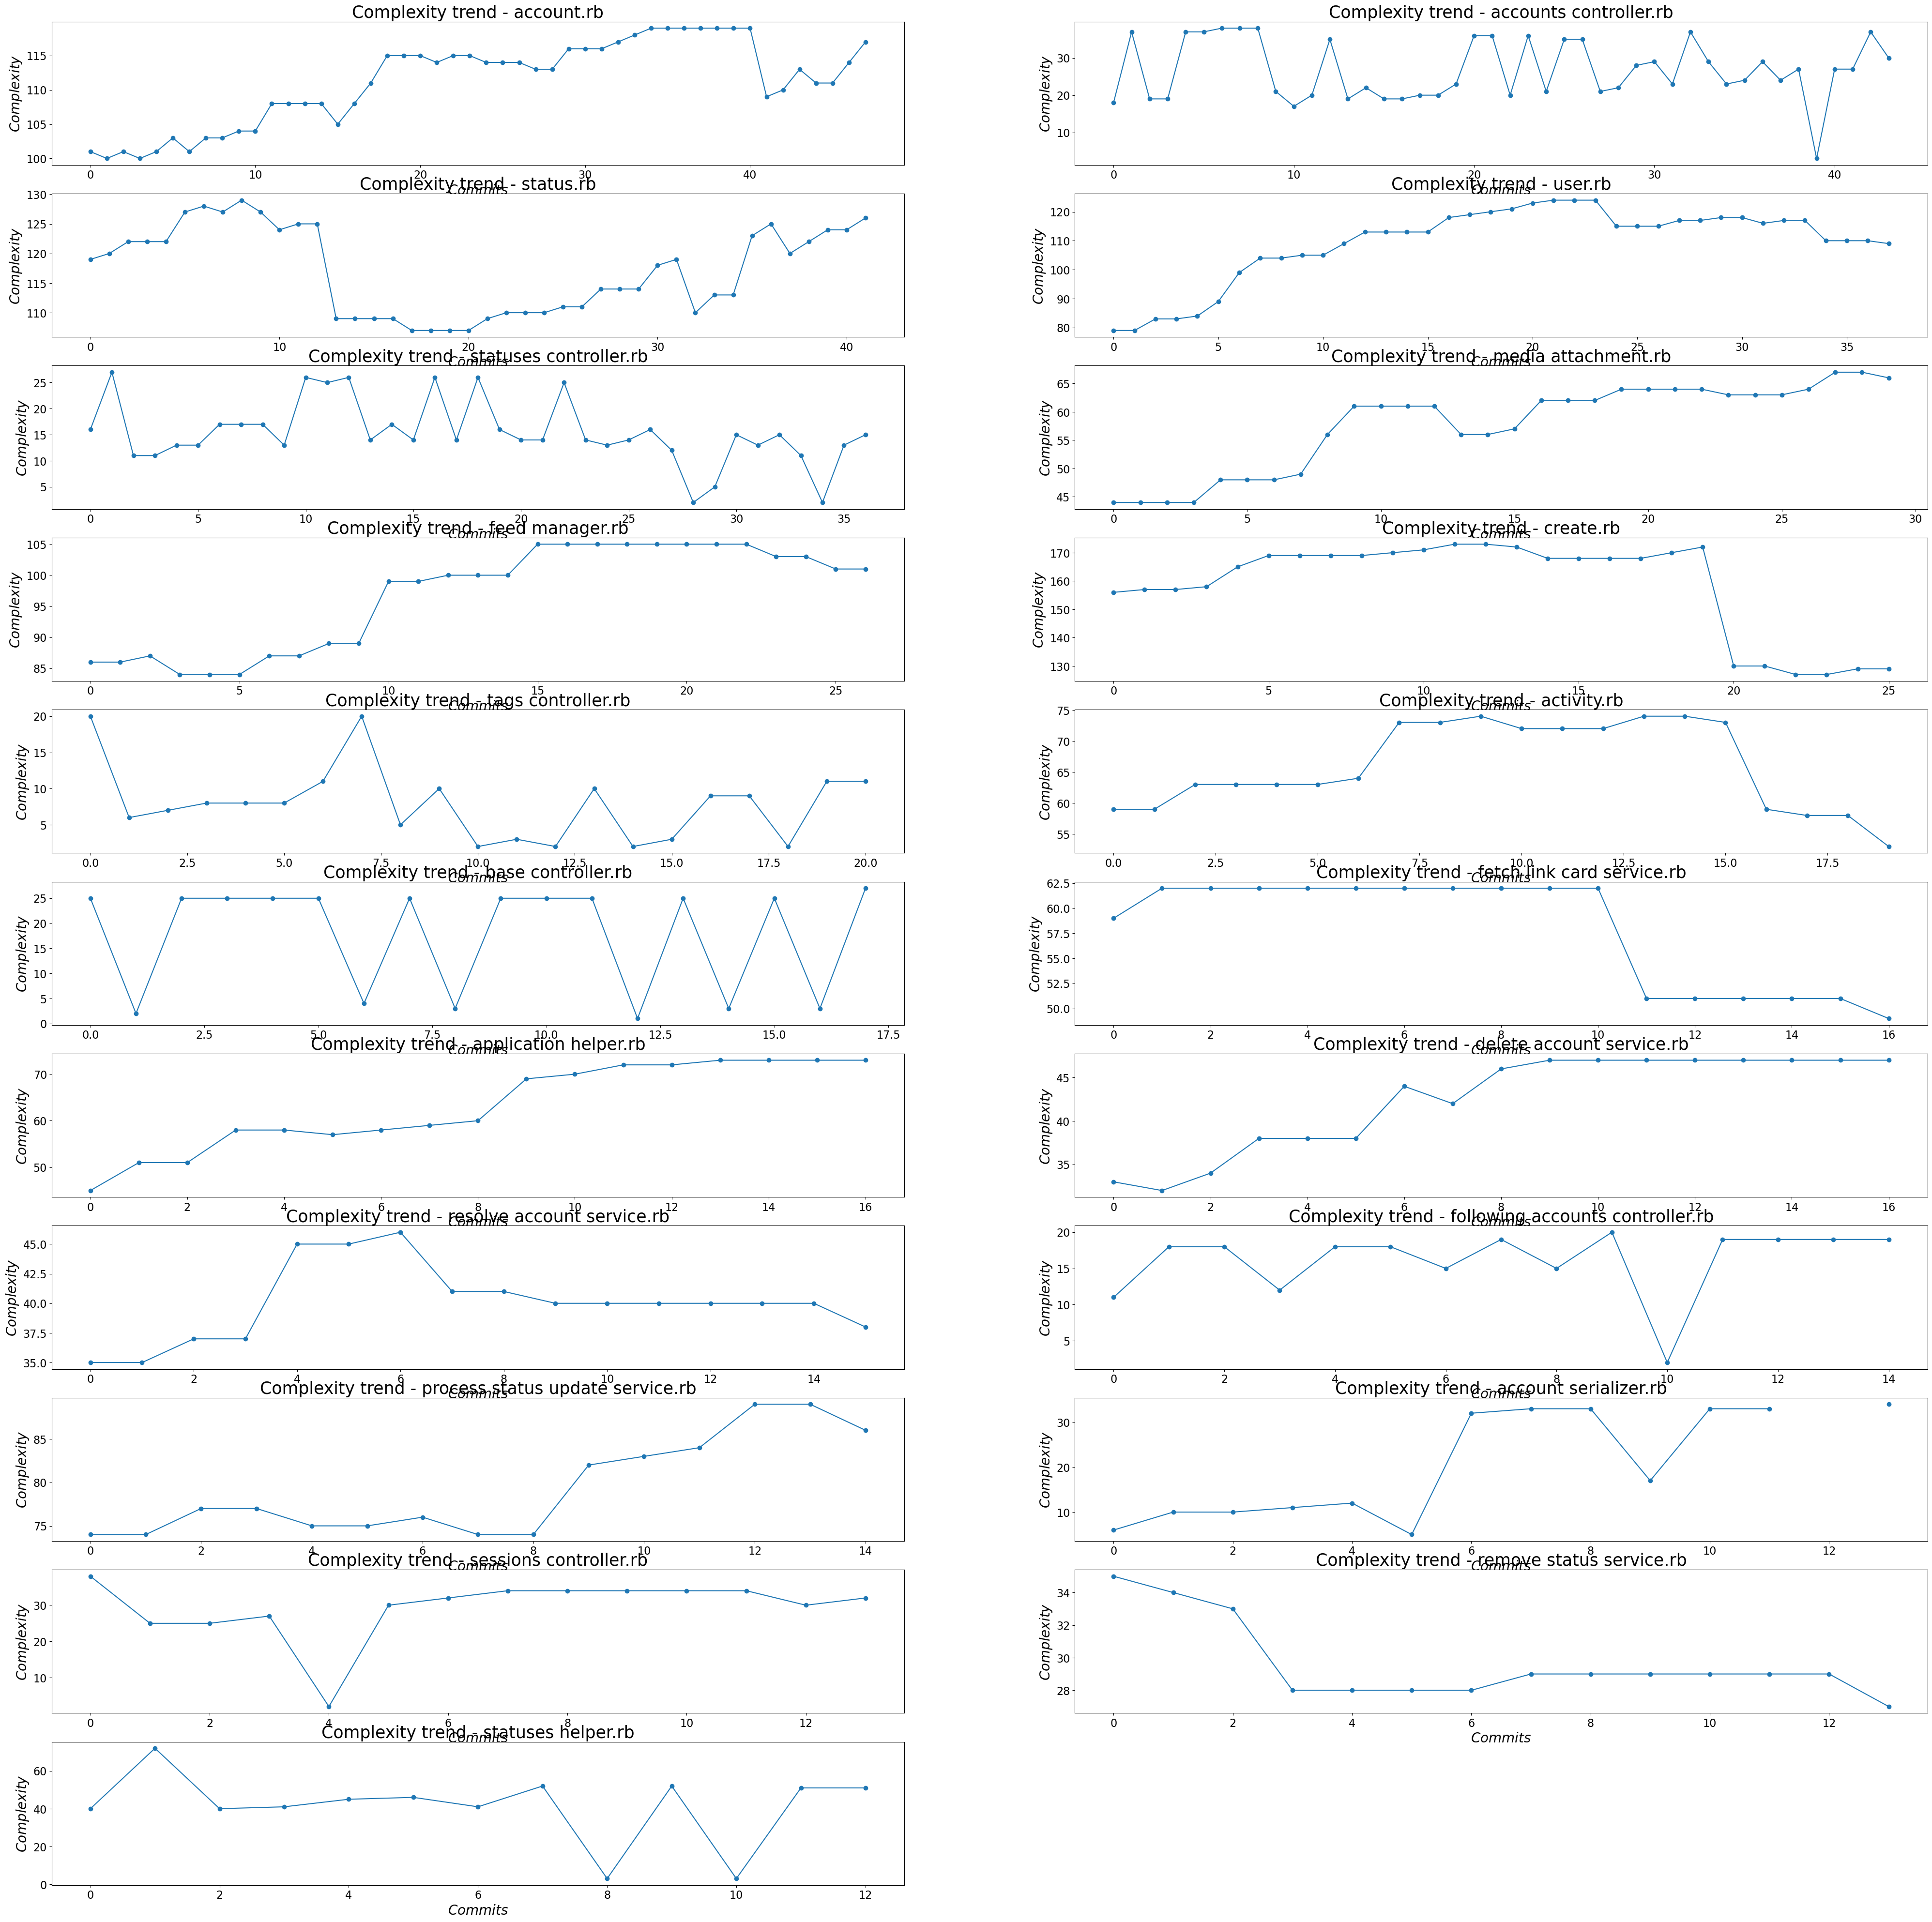

In [20]:
# we study the complexity trend of the entities which are in the top-20 with more modifications. These are our initial
# candidates to be hotspots. The complexity temporal evolution helps us to determine what are our final candidates to
# be hotspots.
number_of_hotspots = 20
plt.figure(figsize=(50,50))
for index, ent in enumerate(entity_changes):  
    plot_complexity_trend(ent, index+1)
    if index == number_of_hotspots:
        break
# adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)
plt.show()